In [215]:
import re

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy.sparse import csr_matrix

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import CategoricalEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [216]:
plt.rcParams['figure.figsize'] = (8, 6)

In [252]:
# Загрузим общую информацию о собранных пользователях
users_df = pd.read_json('./data/active_users.json', orient='records')
users_df.head()

,city.id,city.title,education_form,education_status,faculty,faculty_name,first_name,followers_count,graduation,id,last_name,sex,university,university_name
0,1.0,Москва,Очное отделение,Студент (специалист),1124.0,Институт управления и информационных технологи...,Павел,277,2010.0,4813,Калугин,2,263.0,РУТ (МИИТ) (бывш. МГУПС Императора Николая II)
1,1.0,Москва,Очное отделение,None,2610.0,Факультет психологии,Натали,147,0.0,24499,Красовская,1,1276.0,МГОУ (бывш. МОПИ им. Н. К. Крупской)
2,53.0,Жуковский,Очное отделение,Студентка (специалист),356.0,Финансовый,Татьяна,390,2010.0,34498,Корнилова,1,87.0,Финансовый университет (бывш. ГУМФ)
3,1.0,Москва,Очное отделение,Студент (магистр),477.0,Международный институт экономики и финансов\r\n,Евгений,110,2010.0,42559,Кошелев,2,128.0,НИУ ВШЭ (ГУ-ВШЭ)
4,3910.0,Звенигород,Очное отделение,None,32.0,Механико-математический факультет,Александр,91,2004.0,47788,Соболев,2,2.0,МГУ


In [253]:
# Загрузка сообщений со стены пользователей
texts_df = pd.read_json('./data/all_texts.json', orient='records')
texts_df.head()

,text,user_id
0,💪🏽🔝,4813
1,Сегодня играем финал высшей лиги ЛВЛ сезона 20...,4813
2,,4813
3,Отличный турнир 💪🏽 В отличной копании!,4813
4,,4813


In [256]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [257]:
class TextsAugmenter(BaseEstimator, TransformerMixin):
    def __init__(self, user_column, text_column):
        self.user_column = user_column
        self.text_column = text_column
    
    @staticmethod
    def _augment_user_texts(texts):
        return ' '.join(texts.tolist())

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        augmented_texts = DataFrame(X.groupby(self.user_column)[self.text_column]
                                     .apply(self._augment_user_texts))
        
        return augmented_texts

In [258]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, label=None):
        self.label = label
    
    def fit(self, X, y=None):
        if self.label:
            self.fill_values_ = self.label 
        else:
            self.fill_values_ = X.mode().iloc[0]
        return self
    
    def transform(self, X):
        return X.fillna(self.fill_values_).values

In [259]:
class ArrayDensifier(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()

In [260]:
class ArraySparsifier(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return csr_matrix(X)

In [ ]:
# Стемминг и лемматизация тестировались при подборе параметров модели, 
# но улучшение оценки на кросс-валидации не удалось получить

from nltk.stem import SnowballStemmer

rus_stemmer = SnowballStemmer('russian')
rus_stemmer.stem('volley')

mystem = Mystem()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([rus_stemmer.stem(w) for w in analyzer(doc)])

In [226]:
id_column = 'user_id'

num_columns = ['followers_count']
cat_columns = ['city.title', 'faculty', 'graduation', 'university']
text_column = 'text'
columns = num_columns + cat_columns + [text_column]

target_column = 'sex'

pattern = '([^\W\d_]{4,})'

russian_stops = set(stopwords.words('russian'))
english_stops = set(stopwords.words('english'))
stop_words = russian_stops | english_stops

In [261]:
# Преобразуем все сообщения пользователя в единый текст
text_pipeline = Pipeline([
    ('select columns', ColumnExtractor([id_column, text_column])),
    ('augment user texts', TextsAugmenter(id_column, text_column))
])

In [262]:
augmented_texts_df = text_pipeline.fit_transform(texts_df)
augmented_texts_df.head()

,text
user_id,
4813,💪🏽🔝 Сегодня играем финал высшей лиги ЛВЛ сезон...
34498,"Для тех,кто любит пилатес Итак, подтягивание в..."
42559,...
47788,Всех с наступающим новым годом! Всем всем...
59524,Мама-лошадка 🏇приветствует тебя! И кагбэ намек...


In [263]:
# Объединим общую и текстовую информацию о пользователях
df = pd.merge(users_df, augmented_texts_df, how='left', left_on='id', right_on='user_id')
df['text'] = df['text'].fillna('')
df.head()

,city.id,city.title,education_form,education_status,faculty,faculty_name,first_name,followers_count,graduation,id,last_name,sex,university,university_name,text
0,1.0,Москва,Очное отделение,Студент (специалист),1124.0,Институт управления и информационных технологи...,Павел,277,2010.0,4813,Калугин,2,263.0,РУТ (МИИТ) (бывш. МГУПС Императора Николая II),💪🏽🔝 Сегодня играем финал высшей лиги ЛВЛ сезон...
1,1.0,Москва,Очное отделение,None,2610.0,Факультет психологии,Натали,147,0.0,24499,Красовская,1,1276.0,МГОУ (бывш. МОПИ им. Н. К. Крупской),
2,53.0,Жуковский,Очное отделение,Студентка (специалист),356.0,Финансовый,Татьяна,390,2010.0,34498,Корнилова,1,87.0,Финансовый университет (бывш. ГУМФ),"Для тех,кто любит пилатес Итак, подтягивание в..."
3,1.0,Москва,Очное отделение,Студент (магистр),477.0,Международный институт экономики и финансов\r\n,Евгений,110,2010.0,42559,Кошелев,2,128.0,НИУ ВШЭ (ГУ-ВШЭ),...
4,3910.0,Звенигород,Очное отделение,None,32.0,Механико-математический факультет,Александр,91,2004.0,47788,Соболев,2,2.0,МГУ,Всех с наступающим новым годом! Всем всем...


In [265]:
# Создадим pipeline обработки разных типов признаков и обучения/предсказания модели
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('categorical', Pipeline([
            ('extract', ColumnExtractor(cat_columns)),
            ('impute', CategoricalImputer()),
            ('encode', CategoricalEncoder())
        ])),
        ('numeric', Pipeline([
            ('extract', ColumnExtractor(num_columns)),
            ('normalize', MinMaxScaler())
        ])),
        ('text', Pipeline([
            ('extract', ColumnExtractor(text_column)),
            ('vectorize', TfidfVectorizer()),
        ])),
    ])),
    ('clf', MultinomialNB())
])

In [267]:
# Разделим данные датасет и целевой признак
X = df.drop(target_column, axis=1)
y = df[target_column]
X.shape, y.shape

((234, 14), (234,))

In [268]:
# Разделим данные на тренировочный и тестовый датасеты
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((210, 14), (24, 14), (210,), (24,))

In [269]:
# Проведем поиск параметров модели
# В связи с большим кол-вом итераций поиска параметров, отображены только финальные значения
# Все указанные ниже параметры использовались для тюнинга модели
param_grid = {'clf': [MultinomialNB()],
              'clf__alpha': [0.05],
              'features__categorical__impute__label': [None],
              'features__categorical__encode__encoding': ['onehot'],
              'features__categorical__encode__handle_unknown': ['ignore'],
              'features__text__vectorize__analyzer': ['word'],
              'features__text__vectorize__lowercase': [True],
              'features__text__vectorize__stop_words': [stop_words],
              'features__text__vectorize__token_pattern': [pattern],
              'features__text__vectorize__min_df': [4],
              'features__text__vectorize__max_df': [70],
              'features__text__vectorize__sublinear_tf': [True],
              'features__text__vectorize__max_features': [25000],
              'features__text__vectorize__ngram_range': [(1, 1)],
              'features__text__vectorize__use_idf': [True],
              'features__text__vectorize__smooth_idf': [True],
              'features__text__vectorize__strip_accents': [None]}

grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
grid_search.fit(X_train, y_train)
grid_search.best_score_

0.7235478411949001

In [270]:
roc_auc_score(y_test, grid_search.predict(X_test))

0.70833333333333337

<module 'matplotlib.pyplot' from '/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/matplotlib/pyplot.py'>

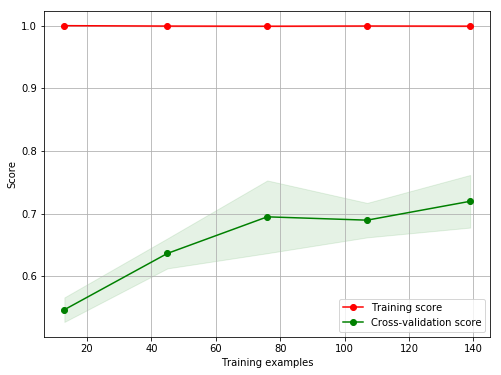

In [271]:
# Построим learning curve для определения, достаточно ли данных для модели

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        random_state=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        shuffle=True, random_state=random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(grid_search, '', X_train, y_train, cv=3, random_state=42)

Как можно видеть из learning curve, модель недообучена, и возможно улучшение при добавлении дополнительных данных и признаков. Однако по причине длительного времени сбора данных, в данном случае используется небольшой датасете.

Text(51,0.5,'Predicted labels')

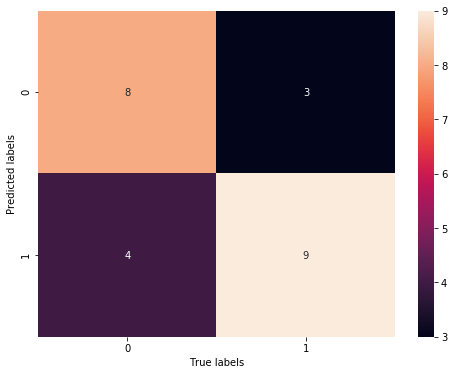

In [272]:
# Посмотрим на распределение ошибок предсказания
y_pred = grid_search.predict(X_test)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred).T, annot=True)
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')

In [274]:
# 1й способ сохранить и загрузить обученную модель
from sklearn.externals import joblib

joblib.dump(grid_search.best_estimator_, './models/best_model_joblib.pkl')
clf = joblib.load('./models/best_model_joblib.pkl')
roc_auc_score(clf.predict(X_test), y_test)

0.70979020979020979

In [275]:
# 2й способ сохранить и загрузить обученную модель
import pickle
pickle.dump(grid_search.best_estimator_, open('./models/best_model.pkl', 'wb'))
clf = pickle.load(open('./models/best_model.pkl', 'rb'))
roc_auc_score(clf.predict(X_test), y_test)

0.70979020979020979

### Predict

Проведем тестирование предсказания на отдельном пользователе (до построения Telegram-бота)

In [277]:
from time import sleep
from urllib.parse import urlparse
import requests

In [1]:
url = 'https://api.vk.com/method/{}'
access_token = ''
version = '5.78'

payload = {'v': version, 'access_token': access_token}
payload

{'v': '5.78', 'access_token': ''}

In [279]:
user_url = 'https://vk.com/id24609578'
user_screen_name = urlparse(user_url).path[1:]
user_screen_name

'id24609578'

In [280]:
utils_payload = payload.copy()
utils_payload['screen_name'] = user_screen_name
res = requests.get(url.format('utils.resolveScreenName'), params=utils_payload)
res.json()

{'response': {'type': 'user', 'object_id': 24609578}}

In [281]:
user_id = res.json()['response']['object_id']
user_id

24609578

In [282]:
def get_user_info(user_id, fields):
    users_payload = payload.copy()
    users_payload['user_ids'] = user_id
    users_payload['fields'] = fields
    users_payload

    res = requests.get(url.format('users.get'), params=users_payload)
    
    response_df = pd.io.json.json_normalize(res.json()['response'])
                                            
    user_info_df = DataFrame(columns=columns)
    user_info_df = user_info_df.append(response_df, ignore_index=True, sort=False)
    
    return user_info_df

In [283]:
fields = 'city,education,followers_count,sex'

user_info_df = get_user_info(user_id, fields)
user_info_df

,followers_count,city.title,faculty,graduation,university,text,faculty_name,first_name,id,last_name,sex,university_name
0,105,NaN,0,0,0,NaN,,Ivan,24609578.0,Rudko,2.0,


In [284]:
def get_user_wall_posts(user_id):
    wall_payload = payload.copy()
    wall_count = 100
    wall_payload['count'] = wall_count
    wall_payload['filter'] = 'owner'

    posts_count = 0
    offset = 0
    
    wall_payload['offset'] = offset
    wall_payload['owner_id'] = user_id

    res = requests.get(url.format('wall.get'), params=wall_payload)
    total_wall_count = res.json()['response']['count']

    try:
        posts = res.json()['response']['items']
    except KeyError:
        print('Error: {}'.format(res.json()['error']))
        raise

    print('user_id: {}, # posts: {}'.format(user_id, total_wall_count))

    if not posts:
        all_texts_df = DataFrame({'user_id': [user_id], 'text': ['']}) 
        return all_texts_df
    
    texts = pd.io.json.json_normalize(posts)['text']
    texts_df = DataFrame({'user_id': user_id, 'text': texts})   
    
    all_texts_df = DataFrame(columns = ['user_id', 'text'])
    all_texts_df = all_texts_df.append(texts_df, ignore_index=True)
    posts_count += len(texts)

    while True:
        sleep(0.5)
        offset += wall_count
        wall_payload['offset'] = offset

        res = requests.get(url.format('wall.get'), params=wall_payload)

        try:
            posts = res.json()['response']['items']
        except KeyError:
            print('Error: {}'.format(res.json()['error']))
            raise

        if not posts:
            break

        texts = pd.io.json.json_normalize(posts)['text']
        texts_df = DataFrame({'user_id': user_id, 'text': texts})        
        all_texts_df = all_texts_df.append(texts_df, ignore_index=True)
        posts_count += len(texts)

    print('Total posts count: {}'.format(posts_count))
    
    return all_texts_df

In [285]:
user_texts_df = get_user_wall_posts(user_id)
user_texts_df.head()

user_id: 24609578, # posts: 82
Total posts count: 82


,user_id,text
0,24609578,Ghost in the Shell (2017) - The Opening Scene ...
1,24609578,
2,24609578,http://csharpsourescode.blogspot.ru/2014/10/ap...
3,24609578,
4,24609578,Аффинаж - Нравится


In [286]:
user_text = text_pipeline.fit_transform(user_texts_df)['text'].values
user_info_df.loc[0, 'text'] = user_text
user_info_df.head()

,followers_count,city.title,faculty,graduation,university,text,faculty_name,first_name,id,last_name,sex,university_name
0,105,NaN,0,0,0,Ghost in the Shell (2017) - The Opening Scene ...,,Ivan,24609578.0,Rudko,2.0,


In [287]:
X_test = user_info_df.drop(target_column, axis=1)
y_test = user_info_df[target_column]
X_test.shape, y_test.shape

((1, 11), (1,))

In [288]:
np.round(clf.predict_proba(X_test), 2)

array([[ 0.22,  0.78]])